# Creating Loneliness Index for GPs in Scotland using Prescription Data, 2022

- Outputs an index of loneliness scores for GPs in Scotland for Jan 2022 - Dec 2022
- To be used as an input to map area scores

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
# Path to files
path = "../../extdata/"

# Read drug data

In [3]:
# Get loneliness related conditions and medication data
drug_data = pd.read_csv(path + "drug_list.csv")

# Process Prescribing Data
- Uses "Prescriptions in the Community" .csv files that come from: https://www.opendata.nhs.scot/dataset/prescriptions-in-the-community to identify loneliness related conditions based on prescriptions
- Prescription in the Community are monthly files containing prescriptions made at GP level
- Outputs a dataframe that multiplies loneliness related prescriptions by its count.

*Prescription in the Community csvs need to be saved in the prescriptions_scotland/ folder manually*

In [4]:
# column names
col_bnfname = "BNFItemDescription"
col_items = "NumberOfPaidItems"

In [5]:
# Function to find loneliness related conditions based on prescription
def code_loneliness(x):
    out = {}
    # coding by illness categories
    for illness in drug_data['illness'].unique():
        out[illness] = x[col_bnfname].str.contains("|".join(drug_data[drug_data['illness'] == illness]['medication']),
                                                 case=False, 
                                                 regex=True).fillna(False).astype('int16')
    # Make dataframe
    out = pd.DataFrame(out)
  
    # Return dataframe multiplied by counts of items
    return out.multiply(x[col_items], axis=0)

In [6]:
# Iterate over Prescription in the Community files, call code_loneliness() to count prescriptions 
# to output a df that is grouped by GP practice

monthly_data = []

for file in os.listdir(path + "prescriptions_scotland"):
    # Open prescribing files 
    prescribe = pd.read_csv(path + "prescriptions_scotland\\" + file)
    prescribe.columns = prescribe.columns.str.strip()
    prescribe = prescribe[["GPPractice", col_bnfname, col_items]]
    print(f" Proccessing {file}")

    # Count prescriptions
    loneliness_prescribing = code_loneliness(prescribe[[col_bnfname, col_items]])
    prescribe = prescribe.merge(
        loneliness_prescribing, left_index=True, right_index=True
    )
    del loneliness_prescribing

    # Group by GPPractice and sum prescriptions across the year
    summary = prescribe.groupby("GPPractice", as_index=False).agg(sum)
    monthly_data.append(summary)
    print(f" Completed processing {file}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../../extdata/prescriptions_scotland'

In [23]:
# concatenate all the monthly data together
data = pd.concat(monthly_data, ignore_index = True)

In [24]:
data[data["loneliness"] > 0].head()

,GPPractice,BNFItemDescription,NumberOfPaidItems,depression,alzheimers,blood pressure,hypertension,diabeties,cardiovascular disease,insomnia,addiction,social anxiety,loneliness
0,10002,MAALOX_ORAL SUSP 175MG/200MG/5MLGAVISCON_LIQ O...,9510,594,20,700,704,107,485,41,0,3,1951
1,10017,MAALOX_ORAL SUSP 175MG/200MG/5MLGAVISCON INFAN...,8734,550,35,658,664,89,420,56,0,5,1814
2,10036,GAVISCON ADVANCE_LIQ (ANISEED) S/FGAVISCON ADV...,6136,376,11,579,582,62,344,59,0,6,1434
3,10106,GAVISCON INFANT_ORAL PDR SACHGAVISCON ADVANCE_...,8541,513,34,719,724,106,505,39,1,2,1922
4,10125,MAALOX PLUS_SUSPGAVISCON ADVANCE_TAB CHBLE 500...,6673,425,15,453,454,91,367,44,0,4,1396


In [25]:
# Save aggregated data
data.to_csv(path + "processed_data.csv")

# Join GPs to postcodes

- Use the 'GP Practice Contact Details and List Sizes' data from: https://www.opendata.nhs.scot/dataset/gp-practice-contact-details-and-list-sizes to get GP surgery codes and postcode
- Note that Scotland only publishes these data four times a year (in Jan, Apr, Jul and Oct).

*GP Practice Contact Details and List Sizes csvs need to be saved in the processed_data/ folder manually*

In [86]:
data = pd.read_csv(path + "processed_data.csv", index_col = 0)

In [87]:
# Get GP files
gp_path = path + "gp_data/"

In [88]:
gp_combine = []

for file in os.listdir(gp_path):
    gp_data = pd.read_csv(gp_path + file)
    gp_data = gp_data.rename(columns = {'PracticeCode': 'GPPractice'})
    gp_combine.append(gp_data[['GPPractice','Postcode']])
    print(file)

practice_contactdetails_apr2022-open-data.csv
practice_contactdetails_jan2022.csv
practice_contactdetails_jul2022-open-data.csv
practice_contactdetails_oct2022-open-data.csv


In [89]:
# concatenate all the gp data together
gp_data = pd.concat(gp_combine, ignore_index = True)

In [90]:
gp_data.head(3)

,GPPractice,Postcode
0,10002,DD2 5NH
1,10017,PH7 3SA
2,10036,PH15 2BL


In [91]:
gp_data.shape

(3663, 2)

In [92]:
# drop duplicates as contact details will be repeated across quarters
gp_data.drop_duplicates(inplace = True)
gp_data.shape

(945, 2)

In [93]:
# Join gp data to prescription data
data = data.merge(gp_data, how = 'left', on = ['GPPractice'])

In [94]:
data.head(2)

,GPPractice,BNFItemDescription,NumberOfPaidItems,depression,alzheimers,blood pressure,hypertension,diabeties,cardiovascular disease,insomnia,addiction,social anxiety,loneliness,Postcode
0,10002,MAALOX_ORAL SUSP 175MG/200MG/5MLGAVISCON_LIQ O...,9510,594,20,700,704,107,485,41,0,3,1951,DD2 5NH
1,10017,MAALOX_ORAL SUSP 175MG/200MG/5MLGAVISCON INFAN...,8734,550,35,658,664,89,420,56,0,5,1814,PH7 3SA


In [95]:
print(data.shape)
data.drop_duplicates(inplace = True)
print(data.shape)

In [97]:
data['pcstrip'] = data['Postcode'].str.replace("\s","").str.replace(" ","")

In [98]:
# Check all GPs have postcode
data.pcstrip.isna().value_counts()

pcstrip
False    11265
True      2027
Name: count, dtype: int64

In [99]:
print(f" {2027/11265*100}% of GPs don't have postcodes. Nothing we can do about it, have to drop those GPs.")

 17.993786063027077% of GPs don't have postcodes. Nothing we can do about it, have to drop


In [102]:
data = data.dropna(subset = ['pcstrip'])

In [104]:
data.shape

(11265, 15)

In [105]:
# Sum values by postcode to get total prescriptions across the year
data = data.groupby(["pcstrip"], as_index=False).sum()

In [108]:
data.shape

(739, 15)

In [106]:
# Check for 1 postcode per Practice Code
pc_prac_counts = data.groupby('GPPractice')['pcstrip'].unique().map(len)
pc_prac_counts[pc_prac_counts > 1].count()

2

In [107]:
pc_prac_counts[pc_prac_counts > 1].value_counts()

pcstrip
2    2
Name: count, dtype: int64

Some Practice Codes have more than one postcode associated with them. Possible reasons for this are:
* Practices move to a new location.
* Practices are assigned a new postcode but don't physically move.
* Practice postcodes are wrongly entered at a particular wave and subsequently fixed.

There are 2 practices codes which have more than 1 postcode assigned to them, this is about 1.3% of unique practices.

All 2 practices have 2 postcodes associated with them.

We'll ignore this for now - this will require some more advanced cleaning - useful to be aware of though.

In [109]:
# Save aggregated data
data.to_csv(path + "processed_data_with_postcode.csv")

# Generate Statistics from Prescribing Counts

- Compute percentages per condition as total of all drugs prescribed per postcode
- Compute z-score per condition across postcodes
- Add z-scores of all conditions together to compute a loneliness score per postcode
- The loneliness variable is an equally weighted index of the conditions.


In [110]:
data = pd.read_csv(path + "processed_data_with_postcode.csv", index_col=0)

In [114]:
data.head(2)

,pcstrip,NumberOfPaidItems,depression,alzheimers,blood pressure,hypertension,diabeties,cardiovascular disease,insomnia,addiction,social anxiety,loneliness
0,AB101NW,123460,9241,213,7959,8085,1287,5006,714,108,150,24654
1,AB101QB,125712,8686,229,10289,10409,1427,6904,828,291,794,28774


In [113]:
data = data.drop(columns = ['Postcode','GPPractice', 'BNFItemDescription'])
data.head(2)

,pcstrip,NumberOfPaidItems,depression,alzheimers,blood pressure,hypertension,diabeties,cardiovascular disease,insomnia,addiction,social anxiety,loneliness
0,AB101NW,123460,9241,213,7959,8085,1287,5006,714,108,150,24654
1,AB101QB,125712,8686,229,10289,10409,1427,6904,828,291,794,28774
2,AB101UT,19341,1359,24,1539,1561,218,1108,149,141,23,4560
3,AB101YE,160982,12430,381,9673,9784,2169,7062,1412,531,230,33769
4,AB107QQ,139581,10263,244,8259,8386,1556,6288,919,435,146,28091
...,...,...,...,...,...,...,...,...,...,...,...,...
734,ZE29DY,18236,1227,38,2134,2172,236,1265,25,0,0,4963
735,ZE29HX,72737,4885,129,6474,6538,1037,5783,133,0,35,18505
736,ZE29NA,39351,1955,69,5138,5155,599,2818,19,0,10,10615
737,ZE29QJ,57995,3769,67,7461,7497,919,3539,194,0,91,15985


In [116]:
data.pcstrip.nunique() == len(data)

True

In [117]:
# Generate percentages
perc_cols = drug_data['illness'].unique()
target_cols = perc_cols + '_perc'

# Percentages for discrete illness groups out of total drugs prescribed
data[target_cols] = data[perc_cols].divide(data[col_items], axis=0) * 100


In [118]:
data.head(3)

,pcstrip,NumberOfPaidItems,depression,alzheimers,blood pressure,hypertension,diabeties,cardiovascular disease,insomnia,addiction,...,loneliness,depression_perc,alzheimers_perc,blood pressure_perc,hypertension_perc,diabeties_perc,cardiovascular disease_perc,insomnia_perc,addiction_perc,social anxiety_perc
0,AB101NW,123460,9241,213,7959,8085,1287,5006,714,108,...,24654,7.485015,0.172526,6.446622,6.548680,1.042443,4.054755,0.578325,0.087478,0.121497
1,AB101QB,125712,8686,229,10289,10409,1427,6904,828,291,...,28774,6.909444,0.182162,8.184581,8.280037,1.135134,5.491918,0.658648,0.231481,0.631602
2,AB101UT,19341,1359,24,1539,1561,218,1108,149,141,...,4560,7.026524,0.124089,7.957189,8.070937,1.127139,5.728763,0.770384,0.729021,0.118918


## Standardisation

In [119]:
# Calculate the z scores per illness

# Make new column names.
per_cols = ['depression_perc', 'alzheimers_perc', 'blood pressure_perc', 'hypertension_perc', 
            'diabeties_perc', 'cardiovascular disease_perc', 'insomnia_perc', 'addiction_perc',
            'social anxiety_perc']

# Calculate Z-scores for each column
for i, col in enumerate(per_cols):
    col_zscore = col[:-5] + 'zscore'  # New column name for Z-scores
    data[col_zscore] = stats.zscore(data[col])


In [120]:
# Add conditions z scores for overall loneliness z score
data['loneliness_zscore'] = data[[ 'depressionzscore', 'alzheimerszscore',
       'blood pressurezscore', 'hypertensionzscore', 'diabetieszscore',
       'cardiovascular diseasezscore', 'insomniazscore', 'addictionzscore',
       'social anxietyzscore']].sum(axis=1)

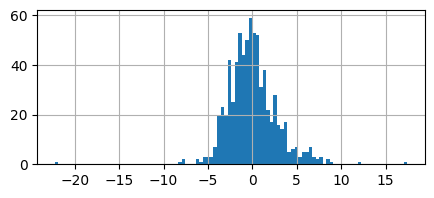

In [123]:
data.loneliness_zscore.hist(bins=100, figsize = (5,2));

In [124]:
data.rename(columns={'pcstrip':'postcode'}, inplace = True)

In [125]:
data = data[['postcode','loneliness_zscore']]

In [126]:
data

,postcode,loneliness_zscore
0,AB101NW,-1.979632
1,AB101QB,7.784077
2,AB101UT,2.910320
3,AB101YE,1.199900
4,AB107QQ,-1.607957
...,...,...
734,ZE29DY,5.640572
735,ZE29HX,3.841375
736,ZE29NA,6.569690
737,ZE29QJ,8.485446


In [128]:
# Save aggregated data
data.to_csv(path + "scotland_gp_2022.csv", index = False)